In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import h5py
import zindex.zindex as zz
import matplotlib.pyplot as plt

/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


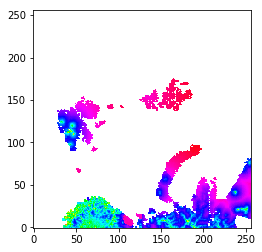

CPU times: user 287 ms, sys: 335 ms, total: 623 ms
Wall time: 724 ms


In [3]:
%%time

def z_interpolate(sorted_interleaved, region_bounds, 
                  global_bounds, width, zoom=32):
    tile_width = (global_bounds[2] - global_bounds[0]) / 2 ** zoom

    xmin = region_bounds[0]
    xmax = region_bounds[2]
    ymin = region_bounds[1]
    ymax = region_bounds[3]
    
    X, Y = np.mgrid[xmin:xmax:complex(0,width), ymin:ymax:complex(0,width)]
    
    positions = np.vstack([X.ravel(), Y.ravel()]).T
    int_points = ((positions - global_bounds[0]) // tile_width).astype(np.uint64)
    x = zz.interleave(int_points[:,0][:], int_points[:,1][:])  

    # print(positions[:10])

    indeces = np.searchsorted(sorted_interleaved, x)
    # points = ordered_points[indeces[indeces < len(ordered_points)]]
    # fpositions = positions[indeces < len(ordered_points)]
    
    return (indeces, positions)

def tile_data(z, x, y):
    '''
    Get interpolated values for a tile as defined by the 
    zoom level (z), x position (x), y position (y) and 
    '''
    tile_width = 360 / 2 ** z
    
    tile_x = -180 + x * tile_width
    tile_y = -180 + y * tile_width
    
    bounds = [tile_x, tile_y, 
              tile_x + tile_width, 
              tile_y + tile_width]
    
    f = h5py.File('../data/points.hdf5', 'r')
    tile_pixels = 256
    sorted_interleaved = f['interleaved']
    sorted_points = f['sorted_points'][:]
    sorted_poi = f['values'][:]
    
    (ixs, positions) = z_interpolate(
        f['interleaved'],
        region_bounds=bounds,
        global_bounds=[-180,-180,180,180],
        width=tile_pixels
    )
    ixs[ixs == len(sorted_interleaved)] = len(sorted_interleaved) - 1
    
    residuals = ((positions - sorted_points[ixs]) ** 2).sum(axis=1)
    new_array = sorted_poi[ixs]
    new_array[residuals > 1] = np.nan

    mat = new_array.reshape((tile_pixels,tile_pixels))

    # mat = sorted_poi[ixs].reshape((tile_pixels, tile_pixels))
    
    return mat

mat = tile_data(2,2,3)
plt.imshow(np.log(mat.T), origin='lower', cmap='hsv')
plt.show()

In [4]:
def tileset_info():
    return {
        'min_pos': [-180, -180],
        'max_pos': [180, 180],
        'max_width': 360,
        'max_zoom': 8
    }

In [18]:
f = lambda z,x,y: ((z,x,y), hgfo.format_dense_tile(tile_data(z, x, y)))
f(0,0,0)

/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


((0, 0, 0),
 {'dense': 'AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH+kSkRIAADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/AADAfwAAwH8AAMB/

In [23]:
import hgflask.server as hgse
import hgflask.tilesets as hfti
import hgtiles.format as hgfo
import hgtiles.utils as hgut

ts = hfti.Tileset(
    tileset_info=tileset_info,
    tiles=lambda tile_ids: hgut.bundled_tiles_wrapper_2d(tile_ids,
                    lambda z,x,y,width=1,height=1: 
                        [((z,x,y), hgfo.format_dense_tile(tile_data(z, x, y)))])
)

server = hgse.start([ts])

terminating: Xsvu2BvNRnWhiTfbeSF2SQ


 * Running on http://0.0.0.0:54679/ (Press CTRL+C to quit)


sleeping


127.0.0.1 - - [07/Nov/2018 08:09:56] "GET /api/v1/tileset_info/?d=a HTTP/1.1" 200 -


ret: 200 b'{\n  "a": {\n    "error": "No such tileset with uid: a"\n  }\n}\n'
returning


/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
127.0.0.1 - - [07/Nov/2018 08:09:57] "GET /api/v1/tiles/?d=BPvmFMN1QnKdQhmVS-CiGQ.0.0.0 HTTP/1.1" 200 -
/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
127.0.0.1 - - [07/Nov/2018 08:10:15] "GET /api/v1/tiles/?d=BPvmFMN1QnKdQhmVS-CiGQ.0.0.0 HTTP/1.1" 200 -
/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
127.0.0.1 - - [07/Nov/2018 08:10:20] "GET /api/v1/tiles/?d=BPvmFMN1QnKdQhmVS-CiGQ.1.0.0 HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2018 08:10:46] "OPTIONS /api/v1/tileset_info/?d=BPvmFMN1QnKdQhmVS-CiGQ&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2018 08:10:46] "GET /api/v1/tileset_info/?d=BPvmFMN1QnKdQhmVS-CiGQ&s=Fg-A-e91QICXV1f0rDxrzw HTTP/1.1" 200 -
1

In [26]:
%%time

x = server.tiles(ts.uuid, 1, 0, 0)

CPU times: user 6.14 ms, sys: 4.46 ms, total: 10.6 ms
Wall time: 186 ms


In [28]:
import higlass_jupyter as hiju
import hgflask.client as hgc

conf = hgc.ViewConf([
    hgc.View([
        hgc.Track(track_type='top-axis', position='top'),
        hgc.Track(track_type='left-axis', position='left'),
        hgc.Track(track_type='heatmap', position='center',
                 tileset_uuid=ts.uuid,
                  api_url=server.api_address,
                  height=250),

    ])
])

hiju.HiGlassDisplay(viewconf=conf.to_json())

track.position top
track.position left
track.position center


A Jupyter Widget